# CNN assignment

<i>Iris van den Boomen<br>
AI-A-RB01</i>

For this assignment I followed the <a style="color:darkblue;" href="https://www.tensorflow.org/tutorials/images/transfer_learning">Transfer learning and fine-tuning</a> tutorial by TensorFlow. The dataset that is used has images of cats and dogs.

## Importing the libraries

The following libraries are imported. 
<ulL>
<li>matplotlib.pyplot: a data visualization library. Pyplot is used for creating various types of plots.</li>
<li>numpy: a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.</li>
<li>os: provides functions for interacting with the operating system (used for tasks like navigating directories, creating folders, etc.).</li>
<li>tensorflow: machine learning framework.</li>
</ul>

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import tensorflow as tf 

## Data preprocessing

### Data download

The data is downloaded and extracted as it is a zip file. Two paths are created, one for the training images and one for the validation images. The batch size is specified, there are 32 images per batch. The image size is also specified, it is 160x160 pixels. Then a training dataset is created, which has 2 classes, with in total 2000 images. 

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip' 
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True) 
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered') 

train_dir = os.path.join(PATH, 'train') 
validation_dir = os.path.join(PATH, 'validation') 

BATCH_SIZE = 32 
IMG_SIZE = (160, 160) 

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE) 

Found 2000 files belonging to 2 classes.


A validation dataset is created which has 2 classes, with in total 1000 images.

In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE) 


Found 1000 files belonging to 2 classes.


A sample of images with the correct labels is shown. 9 images are shown. 

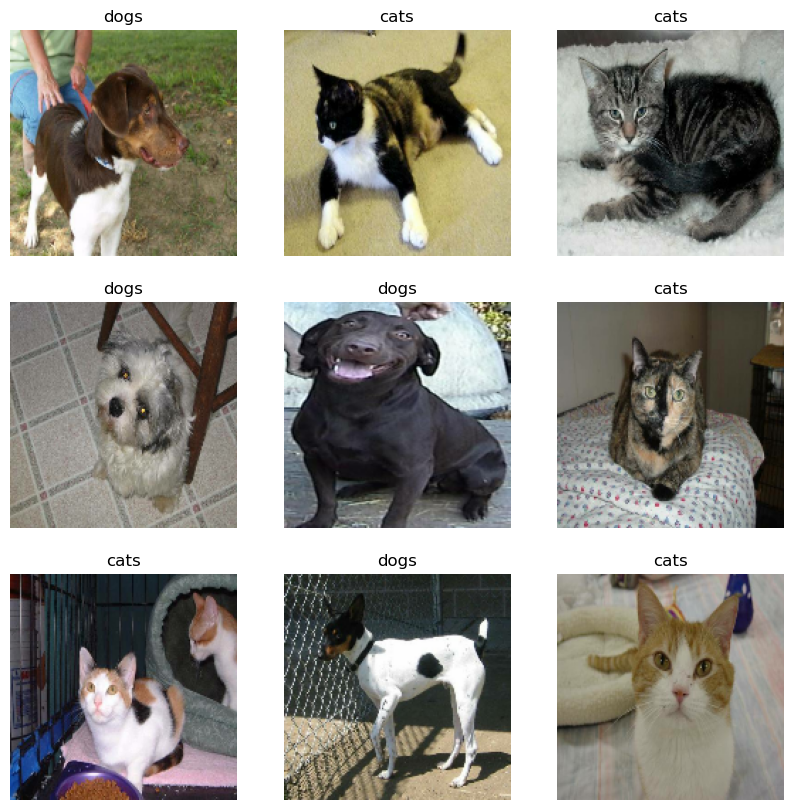

In [4]:
class_names = train_dataset.class_names # the class names of the training dataset. In the training dataset, the cats and dogs are correclty labeled already

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): # looping over the first batch of images and labels of the training dataset
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The original validation dataset is split into two parts -> the validation and test dataset. The test dataset is one-fifth of the original dataset (20%). The remaining data (80%) is the validation data which is used for training. There are 32 batches (32 groups of samples) in this dataset.

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset) 
test_dataset = validation_dataset.take(val_batches // 5) 
validation_dataset = validation_dataset.skip(val_batches // 5)

print(val_batches) 

tf.Tensor(32, shape=(), dtype=int64)


Shown below is the amount of batches in the validation dataset and the test dataset.

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configuring the dataset for performance

Prefetching data is a technique that enhances the efficiency of loading data for training and evaluation in a machine learning model. It takes advantage of parallel processing. This can result in a more smooth and faster training and evaluation process for the model. The value of AUTOTUNE is used to dynamically adjust the buffer size for optimal performance based on the available system resources.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Using data augmentation

On not too large image datasets, it is good to use data augmentation. Data augmentation in deep learning is used to increase the diversity of the training dataset. That is done by applying various transformation to the input images (such as rotation, horizontal flipping, zooming). Doing this helps expose the model to different aspects of the training data and reduce overfitting. <br><br>
A sequential model is used. In the first layer, some of the images in each batch are horizontally flipped. In the second layer, a rotation is applied of max 20%.<br><br>Other techniques that could be used are zooming, cropping, color jittering, etc.

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Visualizing the changes.

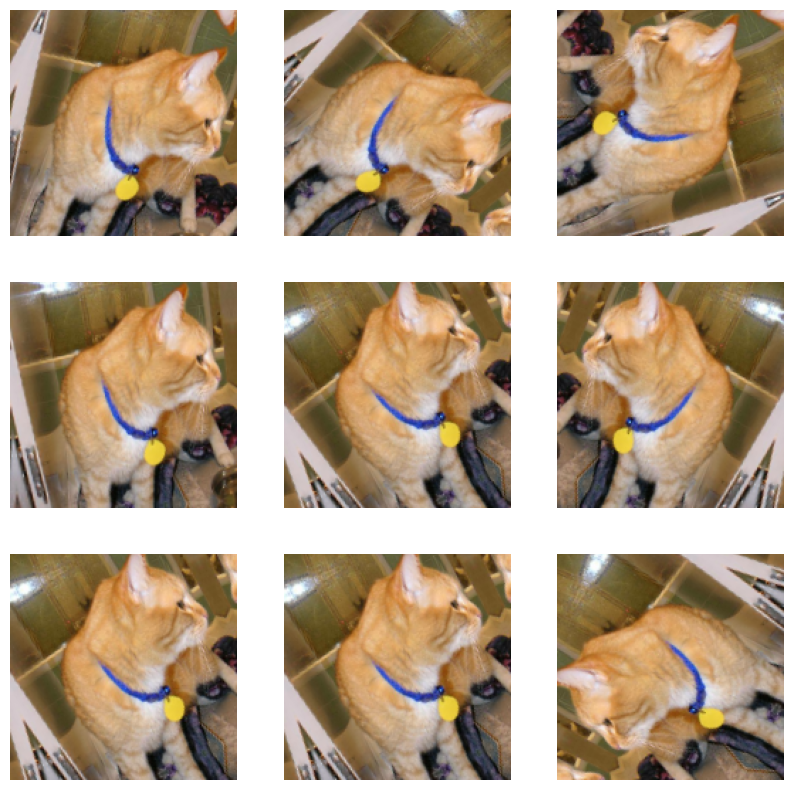

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescaling pixel values

The pixel values are currently in the images are in [0, 255], but the model expects pixel values in [-1, 1]. The preprocessing method can be used to rescale them.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

A layer is created which rescales the pixel values of an image before feeding it into the model.

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Creating the base model from the pre-trained convnets

A base model is created for the image classification using a pre-trained model MobileNet V2. The (3,) is to specify to use 3 color channels (red, green, blue). include_top is set to false, which means the final layer of the model (responsible for classification) is not included. weights='imagenet' means that the pre-trained weights for the MobileNet V2 model are used.

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

A batch of images and their corresponding labels from the training dataset are loaded, passing them through the pre-trained MobileNet V2 model. The result is printed. The printed result is:
<ul>
    <li>32: the batch size</li>
    <li>5: height of the feature maps in units</li>    
    <li>5: widht of the feature maps in units</li>    
    <li>1280: number of channels in each feature map </li>
</ul>

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction

The base_model.trainable is set to false, which prevents the weights of the model from being updated during training.

In [14]:
base_model.trainable = False

A summary of the model is shown below. It includes information about each layer in the model, such as the name and type of the layer, the output shape of the layer (e.g. (None, 80, 80, 32) -> None is for the batch size, 80 and 80 is for the height and width of the feature map and 32 is for the number of channels in the feature map), number of parameters and to which layer it is connected to.

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

A global average pooling layer is created using the GlobalAveragePooling2D() function. This layer takes the output of the pre-trained MobileNet V2 model as input. The goal of this is to reduce the dimensionality of the output feature maps from the pre-trained model. The output stands for 32 samples and 1280 channels.

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Below, a Dense layer is created for making predictions. The Dense layer has one output unit.

In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now a new model is used for the pre-trained model. The input is an image of 160x160 pixels in RGB. The data_augmentation is what is specified above (rotation and horizontal flipping). The output of that is used in the pre_process to normalize the pixel values of the image. Then the preprocessed images are going through the pre-trained model, again false is set so the base model's weight stay the same. The global_average_layer is applied. Then a Dropout layer is applied, the dropout rate is set to 20%, this helps to prevent overfitting during training. The model variable is assigned to create the complete model, it takes an input and outputs a single value that represents the probability that the input image is a dog.

In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Another summary, but now of the new model.

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

We look at the amount of trainable variables. There are 2 in total. After looking at the list, there are 2 trainable variables: the weights and biases.

In [20]:
len(model.trainable_variables)

# for var in model.trainable_variables:
#   print(var.name, var.shape)

2

Somehow this doesn't work, even though pydot and graphviz are installed. Will try to find out why.

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Here the compiling starts before the training. Several things, such as the optimizer, learning rate, loss, etc. are chosen.
BinaryCrossentropy is used, since there are two classes.

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

Before training the model, certain variables are specified. We check what the loss and accuracy is of those before training and then we train the model. The epoch means that it passes through the entire training dataset 10 times. The current loss is 79.68% and the accuracy is 46.78% (before training).

In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


26/26 [==============================] - 7s 212ms/step - loss: 0.8069 - accuracy: 0.4579


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 0.81
initial accuracy: 0.46


Here the training starts. The training and validation loss are quite high at first, but in the end it decreased significantly. The accuracy of both training and validation however increased a lot. This means that the model is learning and improving its performance on both the training and validation data.

In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10


63/63 [==============================] - 28s 397ms/step - loss: 0.7396 - accuracy: 0.5615 - val_loss: 0.5508 - val_accuracy: 0.7550
Epoch 2/10
63/63 [==============================] - 26s 410ms/step - loss: 0.5652 - accuracy: 0.7000 - val_loss: 0.3967 - val_accuracy: 0.8676
Epoch 3/10
63/63 [==============================] - 26s 418ms/step - loss: 0.4331 - accuracy: 0.8235 - val_loss: 0.3141 - val_accuracy: 0.9084
Epoch 4/10
63/63 [==============================] - 25s 396ms/step - loss: 0.3914 - accuracy: 0.8410 - val_loss: 0.2548 - val_accuracy: 0.9307
Epoch 5/10
63/63 [==============================] - 26s 413ms/step - loss: 0.3271 - accuracy: 0.8645 - val_loss: 0.2195 - val_accuracy: 0.9493
Epoch 6/10
63/63 [==============================] - 26s 407ms/step - loss: 0.2920 - accuracy: 0.8945 - val_loss: 0.1845 - val_accuracy: 0.9592
Epoch 7/10
63/63 [==============================] - 29s 468ms/step - loss: 0.2546 - accuracy: 0.9160 - val_loss: 0.1681 - val_accuracy: 0.9653
Epoch 8/10

Two plots to visualize the accuracy and loss on the training data and the data it had never seen before (validation) versus epochs. 

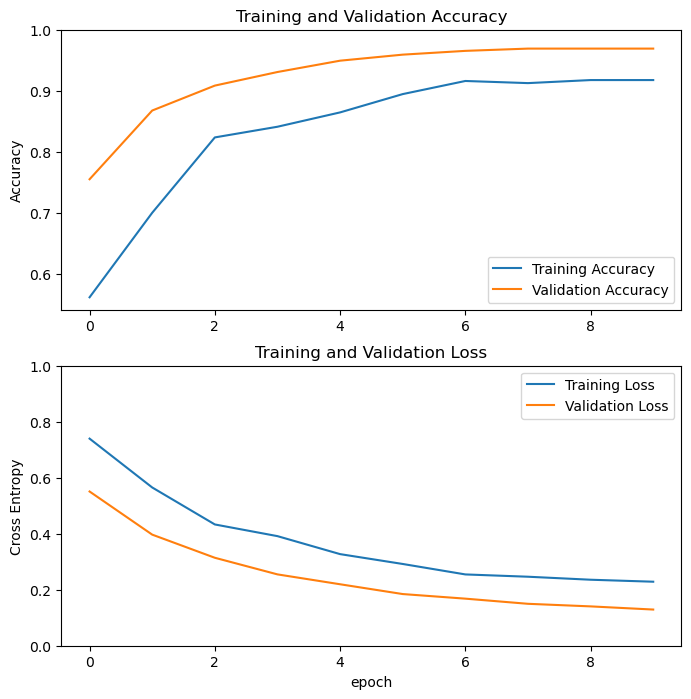

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [27]:
# base_model.trainable = True

In [28]:
# # Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable = False

In [29]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
#               metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [30]:
# model.summary()

In [31]:
# len(model.trainable_variables)

In [32]:
# fine_tune_epochs = 10
# total_epochs =  initial_epochs + fine_tune_epochs

# history_fine = model.fit(train_dataset,
#                          epochs=total_epochs,
#                          initial_epoch=history.epoch[-1],
#                          validation_data=validation_dataset)

In [33]:
# acc += history_fine.history['accuracy']
# val_acc += history_fine.history['val_accuracy']

# loss += history_fine.history['loss']
# val_loss += history_fine.history['val_loss']

In [34]:
# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
# plt.plot([initial_epochs-1,initial_epochs-1],
#           plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [35]:
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

Let's look at one of the batches to see how accurate the model is, it has 32 images. All of the 32 images are correctly classified. Let's also visualize this.

Predictions:
 [1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0]
Labels:
 [1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0]


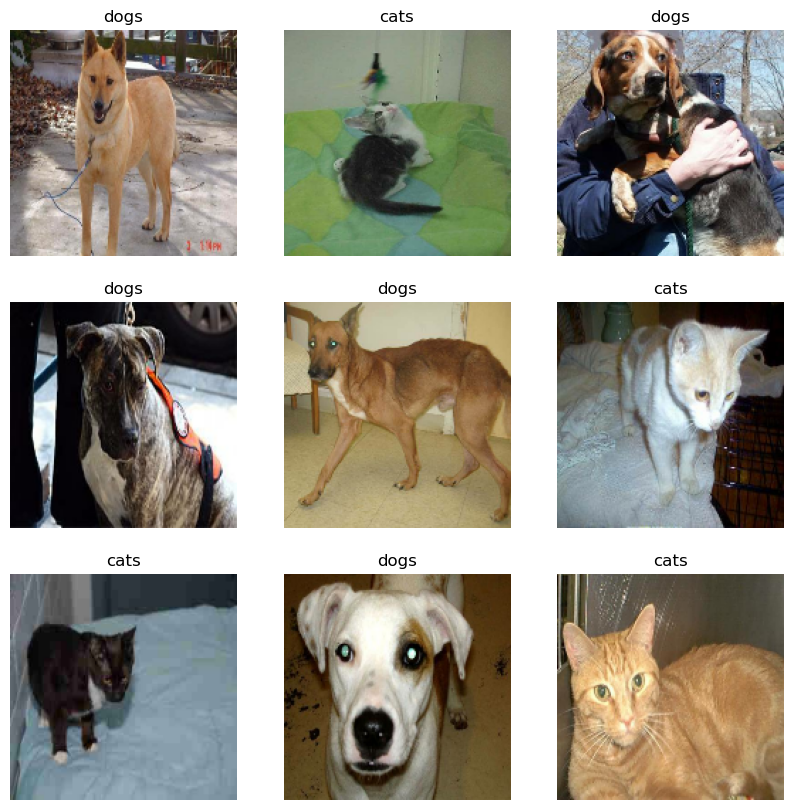

In [39]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Let's look at how accurate the model is. 17 cats were correctly classified as cats and 15 dogs were correctly classified as dogs. Since this is only the first batch, we can look at the other ones as well, to check how accurate it will be.

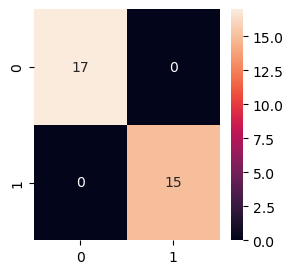

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(3, 3))
cm = confusion_matrix(label_batch, predictions)
sns.heatmap(cm, annot=True)
plt.show()